In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [72]:
train=pd.read_csv('E:\\aqi_prediction\\prototype\\train.csv')
test=pd.read_csv('E:\\aqi_prediction\\prototype\\test.csv')

In [73]:
train.columns

Index(['PM2_5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3',
       'Benzene', 'Toluene', 'Xylene', 'AQI'],
      dtype='object')

In [74]:
train.head()

,PM2_5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
0,142.2700,252.4900,17.11,33.8200,50.910,9.8000,4.3600,17.18,17.6800,0.00,2.63,1.03,325.000000
1,75.6100,121.9400,2.95,27.0300,16.780,15.9200,1.1200,8.24,74.2100,4.93,7.53,1.13,128.000000
2,15.0100,27.6500,3.25,7.9900,9.710,6.0100,0.4800,5.80,29.7800,1.00,2.63,1.03,46.000000
3,14.5275,37.9625,14.39,10.9225,8.085,8.3625,1.3725,53.21,31.8975,0.00,0.00,1.03,95.857143
4,16.6600,97.8200,7.44,28.0000,23.790,28.8300,0.8200,5.03,14.3200,0.09,0.21,1.03,69.000000


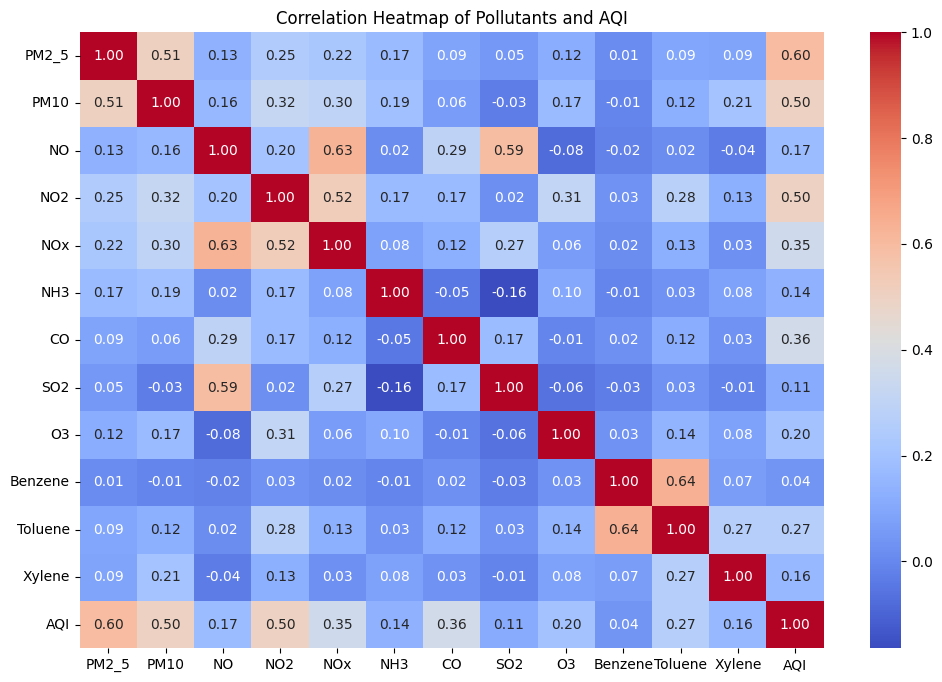

In [75]:
plt.figure(figsize=(12,8))
corr = train.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Pollutants and AQI')
plt.show()

In [78]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#train data
X_train=train.drop('AQI', axis=1)
y_train=train['AQI']

numerical_features=X_train.select_dtypes(include=[np.number]).columns
categorical_features=X_train.select_dtypes(include=['object']).columns
numerical_pipeline=Pipeline(steps=[('scaler', StandardScaler())])
categorical_pipeline=Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('num', numerical_pipeline, numerical_features),('cat', categorical_pipeline, categorical_features)])
X_train_transformed = preprocessor.fit_transform(X_train)

#test data
X_test=test.drop('AQI', axis=1)
y_test=test['AQI']

numerical_features=X_test.select_dtypes(include=[np.number]).columns
categorical_features=X_test.select_dtypes(include=['object']).columns
numerical_pipeline=Pipeline(steps=[('scaler', StandardScaler())])
categorical_pipeline=Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('num', numerical_pipeline, numerical_features),('cat', categorical_pipeline, categorical_features)])
X_test_transformed = preprocessor.fit_transform(X_test)


In [79]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score

In [80]:
model_lr = LinearRegression()
model_rf = RandomForestRegressor()
model_gb = GradientBoostingRegressor()
model_ada = AdaBoostRegressor()
model_dt = DecisionTreeRegressor()
model_xgb = XGBRegressor(verbosity=0)

models = [
    ("Linear Regression", model_lr),
    ("Random Forest", model_rf),
    ("Gradient Boosting", model_gb),
    ("AdaBoost", model_ada),
    ("Decision Tree", model_dt),
    ("XGBoost", model_xgb)
]

for name, model in models:
    print(f"\nModel: {name}")
    model.fit(X_train_transformed, y_train)
    y_pred = model.predict(X_test_transformed)
    r2 = r2_score(y_test, y_pred)
    print(f"R-squared: {r2}")



Model: Linear Regression
R-squared: 0.6329415225679176

Model: Random Forest
R-squared: 0.8399926925235861

Model: Gradient Boosting
R-squared: 0.865418329270496

Model: AdaBoost
R-squared: 0.10930651524459378

Model: Decision Tree
R-squared: 0.7027050078072283

Model: XGBoost
R-squared: 0.871809869795545


In [85]:
catboost_reg=CatBoostRegressor(verbose=0)
catboost_reg.fit(X_train, y_train)

y_pred_cat = catboost_reg.predict(X_test)

r2_cat = r2_score(y_test, y_pred_cat)

print(f"\nCatBoost R-squared: {r2_cat}")


CatBoost R-squared: 0.9073236845657152


In [86]:
y_pred=catboost_reg.predict(X_train)

r2_train_cat = r2_score(y_train, y_pred)

print(f"CatBoost Train R-squared: {r2_train_cat}")

CatBoost Train R-squared: 0.962619036270581


In [84]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor

model = CatBoostRegressor(verbose=0)
param_grid = {
    'depth': [4, 5, 6, 7, 8, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 150, 200, 250, 300]
}

grid = GridSearchCV(model, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)


Best Parameters: {'depth': 8, 'iterations': 300, 'learning_rate': 0.1}
Best Score: 0.8955107877509306


In [87]:
y_pred_grid = grid.predict(X_test)

r2_grid = r2_score(y_test, y_pred_grid)

print(f"\nCatBoost Grid Search R-squared: {r2_grid}")



CatBoost Grid Search R-squared: 0.9095723700830171


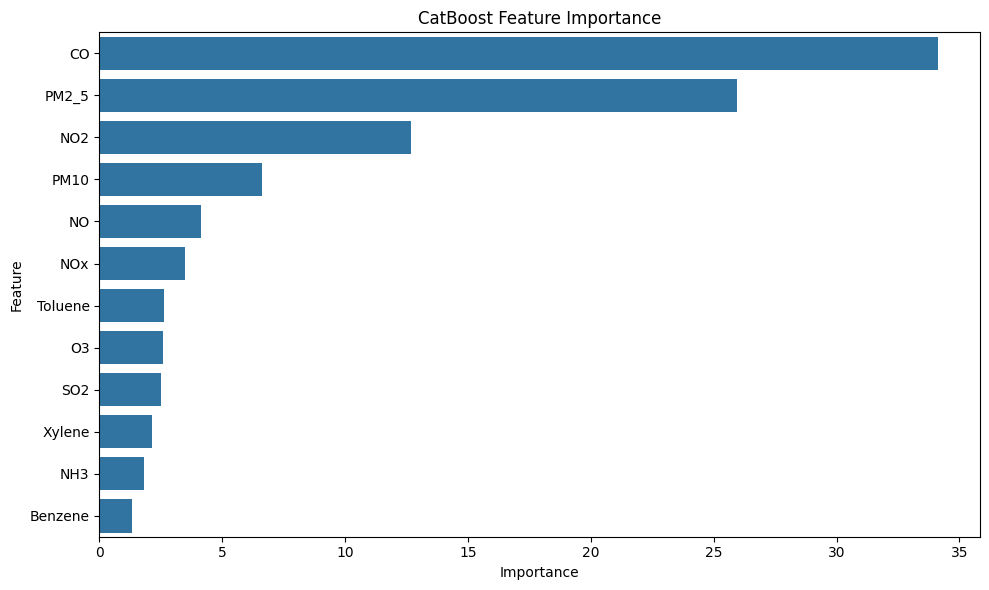

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance
feature_importance = catboost_reg.get_feature_importance()
feature_names = X_train.columns

# Create DataFrame
fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
fi_df.sort_values(by='Importance', ascending=False, inplace=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=fi_df)
plt.title('CatBoost Feature Importance')
plt.tight_layout()
plt.show()


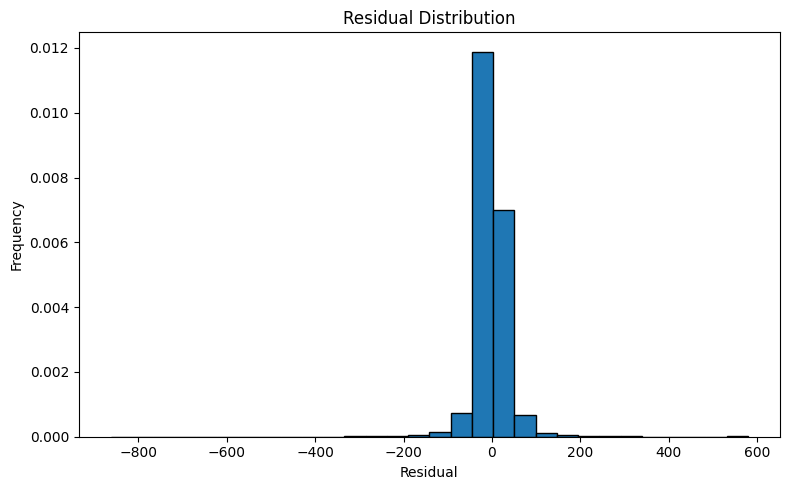

In [ ]:
residuals = y_test - y_pred_cat

plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
